In [1]:
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *
from rsna_retro.train3d import *

Loading imports


In [2]:
torch.cuda.set_device(4)

In [3]:
dls = get_3d_dls_aug(Meta.df_comb, sz=128, bs=32, grps=Meta.grps_stg1)

In [4]:
x,y = dls.one_batch()
x.shape, y.shape, len(dls.train_ds), len(dls.valid_ds)

(torch.Size([32, 60, 3, 128, 128]), torch.Size([32, 60, 6]), 19530, 2214)

## Model

In [5]:
m = get_3d_head()
config=dict(custom_head=m)
learn = get_learner(dls, xresnet18, get_loss(), config=config)

In [6]:
hook = ReshapeBodyHook(learn.model[0])
learn.add_cb(DePadLoss())

In [7]:
learn.load(f'runs/baseline_stg1_xresnet18-3', strict=False)

In [8]:
name = 'train3d_baseline_pretrained'

## Training

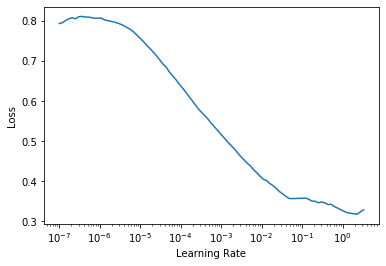

In [17]:
learn.lr_find()

In [14]:
learn.freeze()
learn.fit_one_cycle(1, 1e-2)
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.075200,0.083143,0.973748,0.948756,16:36


In [15]:
learn.save(f'runs/{name}-freeze')

## 256

In [ ]:
dls = get_3d_dls_aug(Meta.df_comb, path=path_jpg256, sz=256, bs=8, grps=Meta.grps_stg1)

In [ ]:
do_fit(learn, 2, 1e-4)
learn.save(f'runs/{name}-1')

## 384 - No 256

In [9]:
learn.load(f'runs/{name}-freeze')

In [12]:
dls = get_3d_dls_aug(Meta.df_comb, path=path_jpg, sz=384, bs=4, grps=Meta.grps_stg1)

In [17]:
do_fit(learn, 4, 1e-4)
learn.save(f'runs/{name}-2-no256')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.077071,0.080323,0.974458,0.950143,17:04
1,0.068472,0.079190,0.975012,0.951480,16:58
2,0.067067,0.078055,0.975348,0.951964,16:47
3,0.067896,0.078203,0.975368,0.951989,16:49


## Test

In [10]:
learn.load(f'runs/{name}-2-no256', strict=True)
sub_fn = f'subm/{name}'

In [13]:
learn.validate()

(#3) [0.078203484416008,0.9753684401512146,0.9519892930984497]

In [10]:
dls = get_3d_dls_aug(Meta.df_tst, sz=384, path=path_tst_jpg, bs=8, test=True)

In [11]:
learn = get_learner(dls, learn.model)
hook.deregister()
hook = ReshapeBodyHook(learn.model[0])
learn.add_cb(DePadLoss())

In [12]:
learn.validate()

AssertionError: ==:
480
48

In [13]:
preds,targs = learn.get_preds()

In [46]:
preds.shape

torch.Size([121232, 6])

In [15]:
pred_csv = submission(Meta.df_tst, preds, fn=sub_fn)

In [52]:
preds.max()

tensor(0.4603)

In [47]:
pred_csv

,ID,Label
0,ID_714683b15_any,0.0030043430
1,ID_714683b15_epidural,0.0003814712
2,ID_714683b15_intraparenchymal,0.0004373344
3,ID_714683b15_intraventricular,0.0003829637
4,ID_714683b15_subarachnoid,0.0036642202
...,...,...
727387,ID_0abae0d75_epidural,0.0000001841
727388,ID_0abae0d75_intraparenchymal,0.0000002477
727389,ID_0abae0d75_intraventricular,0.0000002919
727390,ID_0abae0d75_subarachnoid,0.0000002785


In [16]:
api.competition_submit(f'{sub_fn}.csv', name, 'rsna-intracranial-hemorrhage-detection')

100%|██████████| 26.0M/26.0M [00:02<00:00, 9.57MB/s]


Successfully submitted to RSNA Intracranial Hemorrhage Detection

In [23]:
api.competitions_submissions_list('rsna-intracranial-hemorrhage-detection')[0]

{'ref': 14285598,
 'totalBytes': 27277209,
 'date': '2020-01-25T03:21:22.64Z',
 'description': 'train3d_baseline_pretrained',
 'errorDescription': None,
 'fileName': 'train3d_baseline_pretrained.csv',
 'publicScore': '2.11174',
 'privateScore': '0.38429',
 'status': 'complete',
 'submittedBy': 'Andrew Shaw',
 'submittedByRef': 'bearpelican',
 'teamName': 'Andrew Shaw',
 'type': 'standard',
 'url': 'https://www.kaggle.com/submissions/14285598/14285598.raw'}